In [1]:
import argparse
import sys

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

from sklearn.metrics import accuracy_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import seaborn as sns

In [2]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.n_bits = 2
args.val_size = 0.15
args.test_size = 0.15
args.shuffle = True
args.dict_partition = dict()

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [4]:
tox_types = ['nr-ahr', 'nr-ar-lbd', 
             'nr-ar', 'nr-aromatase', 
             'nr-er-lbd', 'nr-er', 
             'nr-ppar-gamma', 'sr-are', 
             'sr-atad5', 'sr-hse', 
             'sr-mmp', 'sr-p53']

In [5]:
def read_data(filename):
    f = open(filename + '.smiles', 'r')
    contents = f.readlines()
    
    smiles = list()
    labels = list()
    for content in contents:
        smi = content.split()[0]
        label = int(content.split()[2].strip())
        
        smiles.append(smi)
        labels.append(label)
        
    num_total = len(smiles)
    rand_int = np.random.randint(num_total, size=(num_total,))
    
    return np.asarray(smiles)[rand_int], np.asarray(labels)[rand_int]

In [6]:
def get_fingerprint(smile, args):
    mol = Chem.MolFromSmiles(smile)
    arr = np.zeros((1,))
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, args.n_bits)
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    return arr

In [7]:
def make_dataset(smiles, labels, args):
    fps = list()
    toxs = list()
    for i, smile in enumerate(smiles):
        try:
            fp = get_fingerprint(smile, args)
            fps.append(fp)
            toxs.append(labels[i])
        except:
            pass

    return np.asarray(fps), np.asarray(toxs) #(8161,2048), (8161,)

In [8]:
class ToxDataset(Dataset):
    def __init__(self, fps, toxs):
        self.fps = fps
        self.toxs = toxs
        
    def __len__(self):
        return len(self.fps)
    
    def __getitem__(self, index):
        return self.fps[index], self.toxs[index]

In [9]:
def partition(fps, toxs, args):
    num_total = fps.shape[0]
    num_train = int(num_total*(1-args.test_size-args.val_size))
    num_val = int(num_total*args.val_size)
    num_test = int(num_total*args.test_size)
        
    fps_train = fps[:num_train]
    toxs_train = toxs[:num_train]
    fps_val = fps[num_train:num_train+num_val]
    toxs_val = toxs[num_train:num_train+num_val]
    fps_test = fps[num_total-num_test:]
    toxs_test = toxs[num_total-num_test:]
    
    train_set = ToxDataset(fps_train, toxs_train)
    val_set = ToxDataset(fps_val, toxs_val)
    test_set = ToxDataset(fps_test, toxs_test)
    
    #batch[0]: torch.Size([128, 2048])
    #batch[1]: torch.Size([128])
        
    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }
    
    return partition

In [10]:
for tox_type in tox_types:
    args.tox_type = tox_type
    smiles, labels = read_data('tox21/'+tox_type)
    fps, toxs = make_dataset(smiles, labels, args)
    args.dict_partition[args.tox_type] = partition(fps, toxs, args)
    print("Generated and saved partition for " + args.tox_type)

Generated and saved partition for nr-ahr
Generated and saved partition for nr-ar-lbd
Generated and saved partition for nr-ar
Generated and saved partition for nr-aromatase
Generated and saved partition for nr-er-lbd
Generated and saved partition for nr-er
Generated and saved partition for nr-ppar-gamma
Generated and saved partition for sr-are
Generated and saved partition for sr-atad5
Generated and saved partition for sr-hse
Generated and saved partition for sr-mmp
Generated and saved partition for sr-p53


In [11]:
exp_result = dict()

In [12]:
def construct_model(args):
    layers = list()
    layers.append(nn.Linear(args.input_dim, args.hidden_dim))
    layers.append(nn.ReLU())
    
    for i in range(args.n_layers-2):
        layers.append(nn.Linear(args.hidden_dim, args.hidden_dim))
        layers.append(nn.ReLU())
        if args.dropout_rate > 0:
            layers.append(nn.Dropout(args.dropout_rate))
    
    layers.append(nn.Linear(args.hidden_dim, args.output_dim))
    layers.append(nn.Sigmoid())
    
    model = nn.Sequential(*layers)
    return model

In [13]:
def experiment(args):
    model = construct_model(args)
    model.to(args.device)

    dict_train_loss = dict()
    dict_val_loss = dict()
    list_train_loss = list()
    list_val_loss = list()

    optimizer = args.optim(model.parameters(),
                           lr = args.lr,
                           weight_decay=args.l2_coef)

    data_train = DataLoader(args.dict_partition[args.tox_type]['train'],
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(args.dict_partition[args.tox_type]['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        model.train()
        epoch_train_loss = 0
        for i, batch in enumerate(data_train):
            fps = torch.tensor(batch[0], dtype=torch.float, device=args.device)
            toxs = torch.tensor(batch[1], dtype=torch.float, device=args.device)
            toxs = toxs.view(-1, 1)

            optimizer.zero_grad()

            pred_toxs = model(fps)
            pred_toxs.require_grad = False
            train_loss = args.criterion(pred_toxs, toxs)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()

            print("Epoch: ", epoch, "\tbatch: ", i, "\tTraining")

        dict_train_loss[epoch] = epoch_train_loss/len(data_train)
        list_train_loss.append(epoch_train_loss/len(data_train))

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(data_val):
                fps = torch.tensor(batch[0], dtype=torch.float, device=args.device)
                toxs = torch.tensor(batch[1], dtype=torch.float, device=args.device)
                toxs = toxs.view(-1, 1)

                pred_toxs = model(fps)
                val_loss = args.criterion(pred_toxs, toxs)
                epoch_val_loss += val_loss.item()

               

        dict_val_loss[epoch] = epoch_val_loss/len(data_val)
        list_val_loss.append(epoch_val_loss/len(data_val))

    data_test = DataLoader(args.dict_partition[args.tox_type]['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle);

    model.eval()
    acc = 0
    with torch.no_grad():
        list_tox = list()
        list_pred_tox = list()
        list_output = list()
        for i, batch in enumerate(data_test):
            fps = torch.tensor(batch[0], dtype=torch.float, device=args.device)
            toxs = torch.tensor(batch[1], dtype=torch.float, device=args.device)
            toxs = toxs.view(-1, 1)

            pred_toxs = model(fps)

            list_tox += torch.squeeze(toxs).tolist()
            list_pred_tox += pred_toxs.tolist()
            list_output += [0 if x<0.5 else 1 for x in pred_toxs]

            print("Batch: ", i, "\taccuracy: ", "\tTesting")

        acc = accuracy_score(list_tox, list_output)
        roc_auc = roc_auc_score(list_tox, list_pred_tox)

    return model, list_train_loss, list_val_loss, acc, roc_auc

In [14]:
args.batch_size = 128
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.n_layers = 3
args.dropout_rate = 0.5
args.lr = 0.001
args.l2_coef = 0.01
args.optim = optim.Adam
args.criterion = nn.BCELoss()
args.epoch = 10
args.device = 'cuda'

In [15]:
model, list_train_loss, list_val_loss, acc, roc_auc = experiment(args)

Epoch:  0 	batch:  0 	Training
Epoch:  0 	batch:  1 	Training
Epoch:  0 	batch:  2 	Training
Epoch:  0 	batch:  3 	Training
Epoch:  0 	batch:  4 	Training
Epoch:  0 	batch:  5 	Training
Epoch:  0 	batch:  6 	Training
Epoch:  0 	batch:  7 	Training
Epoch:  0 	batch:  8 	Training
Epoch:  0 	batch:  9 	Training
Epoch:  0 	batch:  10 	Training
Epoch:  0 	batch:  11 	Training
Epoch:  0 	batch:  12 	Training
Epoch:  0 	batch:  13 	Training
Epoch:  0 	batch:  14 	Training
Epoch:  0 	batch:  15 	Training
Epoch:  0 	batch:  16 	Training
Epoch:  0 	batch:  17 	Training
Epoch:  0 	batch:  18 	Training
Epoch:  0 	batch:  19 	Training
Epoch:  0 	batch:  20 	Training
Epoch:  0 	batch:  21 	Training
Epoch:  0 	batch:  22 	Training
Epoch:  0 	batch:  23 	Training
Epoch:  0 	batch:  24 	Training
Epoch:  0 	batch:  25 	Training
Epoch:  0 	batch:  26 	Training
Epoch:  0 	batch:  27 	Training
Epoch:  0 	batch:  28 	Training
Epoch:  0 	batch:  29 	Training
Epoch:  0 	batch:  30 	Training
Epoch:  0 	batch: 

Epoch:  5 	batch:  25 	Training
Epoch:  5 	batch:  26 	Training
Epoch:  5 	batch:  27 	Training
Epoch:  5 	batch:  28 	Training
Epoch:  5 	batch:  29 	Training
Epoch:  5 	batch:  30 	Training
Epoch:  5 	batch:  31 	Training
Epoch:  5 	batch:  32 	Training
Epoch:  5 	batch:  33 	Training
Epoch:  5 	batch:  34 	Training
Epoch:  5 	batch:  35 	Training
Epoch:  5 	batch:  36 	Training
Epoch:  5 	batch:  37 	Training
Epoch:  5 	batch:  38 	Training
Epoch:  5 	batch:  39 	Training
Epoch:  5 	batch:  40 	Training
Epoch:  5 	batch:  41 	Training
Epoch:  5 	batch:  42 	Training
Epoch:  5 	batch:  43 	Training
Epoch:  5 	batch:  44 	Training
Epoch:  5 	batch:  45 	Training
Epoch:  5 	batch:  46 	Training
Epoch:  5 	batch:  47 	Training
Epoch:  6 	batch:  0 	Training
Epoch:  6 	batch:  1 	Training
Epoch:  6 	batch:  2 	Training
Epoch:  6 	batch:  3 	Training
Epoch:  6 	batch:  4 	Training
Epoch:  6 	batch:  5 	Training
Epoch:  6 	batch:  6 	Training
Epoch:  6 	batch:  7 	Training
Epoch:  6 	batch

(0.9567233384853169, 0.9081321121287815)

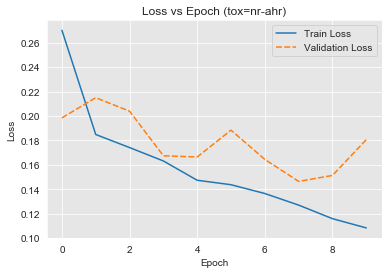

In [16]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

acc, roc_auc

In [17]:
args.batch_size = 128
args.input_dim = 2048
args.hidden_dim = 512
args.output_dim = 1
args.n_layers = 3
args.dropout_rate = 0.5
args.lr = 0.001
args.l2_coef = 0.01
args.optim = optim.Adam
args.criterion = nn.BCELoss()
args.epoch = 10
args.device = 'cuda'

In [ ]:
model, list_train_loss, list_val_loss, acc, roc_auc = experiment(args)

Epoch:  0 	batch:  0 	Training
Epoch:  0 	batch:  1 	Training
Epoch:  0 	batch:  2 	Training
Epoch:  0 	batch:  3 	Training
Epoch:  0 	batch:  4 	Training
Epoch:  0 	batch:  5 	Training
Epoch:  0 	batch:  6 	Training
Epoch:  0 	batch:  7 	Training
Epoch:  0 	batch:  8 	Training
Epoch:  0 	batch:  9 	Training
Epoch:  0 	batch:  10 	Training
Epoch:  0 	batch:  11 	Training
Epoch:  0 	batch:  12 	Training
Epoch:  0 	batch:  13 	Training
Epoch:  0 	batch:  14 	Training
Epoch:  0 	batch:  15 	Training
Epoch:  0 	batch:  16 	Training
Epoch:  0 	batch:  17 	Training
Epoch:  0 	batch:  18 	Training
Epoch:  0 	batch:  19 	Training
Epoch:  0 	batch:  20 	Training
Epoch:  0 	batch:  21 	Training
Epoch:  0 	batch:  22 	Training
Epoch:  0 	batch:  23 	Training
Epoch:  0 	batch:  24 	Training
Epoch:  0 	batch:  25 	Training
Epoch:  0 	batch:  26 	Training
Epoch:  0 	batch:  27 	Training
Epoch:  0 	batch:  28 	Training
Epoch:  0 	batch:  29 	Training
Epoch:  0 	batch:  30 	Training
Epoch:  0 	batch: 

In [ ]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

acc, roc_auc

In [ ]:
args.batch_size = 128
args.input_dim = 2048
args.hidden_dim = 256
args.output_dim = 1
args.n_layers = 3
args.dropout_rate = 0.5
args.lr = 0.001
args.l2_coef = 0.01
args.optim = optim.Adam
args.criterion = nn.BCELoss()
args.epoch = 10
args.device = 'cuda'

In [ ]:
model, list_train_loss, list_val_loss, acc, roc_auc = experiment(args)

In [ ]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

acc, roc_auc

In [ ]:
args.batch_size = 128
args.input_dim = 2048
args.hidden_dim = 128
args.output_dim = 1
args.n_layers = 3
args.dropout_rate = 0.5
args.lr = 0.001
args.l2_coef = 0.01
args.optim = optim.Adam
args.criterion = nn.BCELoss()
args.epoch = 10
args.device = 'cuda'

In [ ]:
model, list_train_loss, list_val_loss, acc, roc_auc = experiment(args)

In [ ]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

acc, roc_auc

In [ ]:
args.batch_size = 128
args.input_dim = 2048
args.hidden_dim = 64
args.output_dim = 1
args.n_layers = 3
args.dropout_rate = 0.5
args.lr = 0.001
args.l2_coef = 0.01
args.optim = optim.Adam
args.criterion = nn.BCELoss()
args.epoch = 10
args.device = 'cuda'

In [ ]:
model, list_train_loss, list_val_loss, acc, roc_auc = experiment(args)

In [ ]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

acc, roc_auc

In [ ]:
args.batch_size = 128
args.input_dim = 2048
args.hidden_dim = 32
args.output_dim = 1
args.n_layers = 3
args.dropout_rate = 0.5
args.lr = 0.001
args.l2_coef = 0.01
args.optim = optim.Adam
args.criterion = nn.BCELoss()
args.epoch = 10
args.device = 'cuda'

In [ ]:
model, list_train_loss, list_val_loss, acc, roc_auc = experiment(args)

In [ ]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

acc, roc_auc

We can see that as hidden dimension decreases exponentially from 1024 to 32, the train loss graph does not change, but the validation loss graph approaches to the train loss graph. The accuracy and roc_auc value is similar. This means that as hidden dimension decreases, the overfitting-ness decreases. Hidden dimension of 1024 has too many parameters, so it just memorizes the train data.